# Linear model try
V1.0  
This version is a first build-up of the whole system. 

V2.0  
This version added "central extraction", in which we only extract the central (0.3~0.9) part of videos for testing set.  
In this way, we try to avoid recognizing frames at the beginning and end of the videos that are not the target gesture as much as possible.  
尽可能避免前后识别出来但不是目标手势的帧

### Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz

from model_dataset import HandshapeDataset, DS_Tools
from paths import *
from model_model import LinearHandshapePredictor
from model_configs import *
from utils import *
from recorder import *
from mio import mk

## Init Model

In [2]:
graphviz.set_jupyter_format('png')

'svg'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = LinearHandshapePredictor(
    input_dim=in_dim, 
    enc_lat_dims=enc_lat_dims, 
    hid_dim=hid_dim, 
    dec_lat_dims=dec_lat_dims, 
    output_dim=out_dim
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Initialize model params

In [4]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

LinearHandshapePredictor(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=63, out_features=32, bias=True)
      (relu): ReLU()
    )
    (1): ResBlock(
      (lin1): Linear(in_features=32, out_features=32, bias=True)
      (lin2): Linear(in_features=32, out_features=32, bias=True)
      (relu): ReLU()
    )
    (2): LinPack(
      (lin): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=8, out_features=16, bias=True)
      (relu): ReLU()
    )
    (1): ResBlock(
      (lin1): Linear(in_features=16, out_features=16, bias=True)
      (lin2): Linear(in_features=16, out_features=16, bias=True)
      (relu): ReLU()
    )
    (2): LinPack(
      (lin): Linear(in_features=16, out_features=32, bias=True)
      (relu): ReLU()
    )
    (3): Linear(in_features=32, out_features=93, bias=True)
  )
)

### Check number of params in model

In [5]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

9125


## Prepare for logs

In [6]:
# Just for keeping records of training hists. 
ts = str(get_timestamp())
# ts = "1012172419"
stop_epoch = "199"
save_subdir = os.path.join(model_save_dir, "{}/".format(ts))
mk(save_subdir)
save_txt_name =  "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_{}.hst".format(ts)
save_valhist_name = "val_{}.hst".format(ts)
save_valacc_name = "valacc{}.hst".format(ts)

valid_losses = LossRecorder(save_subdir + save_valhist_name)
train_losses = LossRecorder(save_subdir + save_trainhist_name)
valid_accuracies = LossRecorder(save_subdir + save_valacc_name)
text_hist = HistRecorder(save_subdir + save_txt_name)

print("NOTE: {} is the series number this time. ".format(ts))

NOTE: 1012211003 is the series number this time. 


### Switch for loading saved records

In [7]:
READ = False
# READ = True

if READ: 
    valid_losses.read()
    train_losses.read()
    valid_accuracies.read()

    model_raw_name = "CP_{}_{}".format(ts, stop_epoch)
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(save_subdir, model_name)
    state = torch.load(model_path)
    model.load_state_dict(state)
    model.to(device)

## Dataset and Dataloader

### Data and Tag Paths

In [8]:
data_path = os.path.join(data_dir, data_name + "_data.npz")
tag_path = os.path.join(data_dir, data_name + "_tag.npz")

### Create Dataset

In [9]:
ds = HandshapeDataset(data_path, tag_path)
if READ: 
    valid_ds_indices = DS_Tools.read_indices(os.path.join(save_subdir, "valid_ds_{}.pkl".format(ts)))
    all_indices = list(range(len(ds)))
    train_ds_indices = list(set(all_indices).difference(set(valid_ds_indices)))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)
else: 
    train_len = int(0.9 * len(ds))
    valid_len = len(ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(ds, [train_len, valid_len])
    DS_Tools.save_indices(os.path.join(save_subdir, "valid_ds_{}.pkl".format(ts)), valid_ds.indices)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)
valid_num = len(valid_loader.dataset)


### Check size of dataset

In [10]:
print(train_num, valid_num)

18208 2024


### Save model structure

In [11]:
model_graph = draw_graph(model, input_size=(BATCH_SIZE, length, original_dim), 
                         save_graph=True, filename=save_subdir + "model_{}".format(ts))

## Training

### Define validation set cut range

In [12]:
cut_range = (0.3, 0.8)
# cut_range = None

In [13]:
BASE = 0
EPOCHS = 300

In [14]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, tags) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x = DS_Tools.cut_frames(x, cut_range=cut_range)
            tags = DS_Tools.cut_frames(tags, cut_range=cut_range)

            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            
            preds = model(x)

            loss = criterion(preds, tags)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "CP_{}_{}.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(save_subdir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_correct = 0
        valid_total = 0
        valid_num = len(valid_loader)
        for idx, (x, tags) in enumerate(valid_loader):
            x = DS_Tools.cut_frames(x, cut_range=cut_range)
            tags = DS_Tools.cut_frames(tags, cut_range=cut_range)

            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            preds = model(x)    # (B, C)

            loss = criterion(preds, tags)

            valid_loss += loss.item()


            predicted = torch.argmax(nn.Softmax(dim=1)(preds), dim=1)
            valid_total += tags.size(0)
            valid_correct += (predicted == tags).sum().item()

            if idx % 100 == 0:
                # \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f}
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)
        valid_accuracies.append((100 * valid_correct / valid_total))
        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")
        text_hist.print(f"※※※Valid accuracy {(100 * valid_correct / valid_total): .3f} %※※※")

In [15]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  4.532 in Step 0
Training loss  3.928 in Step 100
Training loss  3.252 in Step 200
Training loss  3.437 in Step 300
Training loss  3.848 in Step 400
Training loss  3.479 in Step 500
※※※Training loss  3.607※※※
Training timepoint saved
Valid loss  3.342 in Step 0
※※※Valid loss  3.512※※※
※※※Valid accuracy  9.486 %※※※
Epoch 1
Training loss  3.294 in Step 0
Training loss  3.636 in Step 100
Training loss  3.180 in Step 200
Training loss  3.863 in Step 300
Training loss  3.217 in Step 400
Training loss  3.864 in Step 500
※※※Training loss  3.517※※※
Training timepoint saved
Valid loss  3.289 in Step 0
※※※Valid loss  3.501※※※
※※※Valid accuracy  10.474 %※※※
Epoch 2
Training loss  3.405 in Step 0
Training loss  3.367 in Step 100
Training loss  3.303 in Step 200
Training loss  3.450 in Step 300
Training loss  3.578 in Step 400
Training loss  3.283 in Step 500
※※※Training loss  3.511※※※
Training timepoint saved
Valid loss  3.353 in Step 0
※※※Valid loss  3.505※※※
※※※Valid accura

In [16]:
### Save
valid_losses.save()
valid_accuracies.save()
train_losses.save()
text_hist.save()

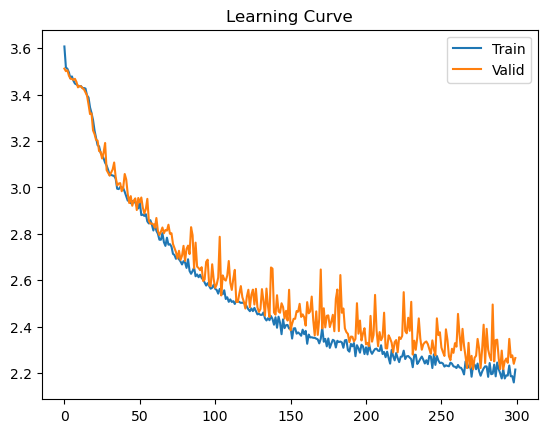

In [17]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve")
plt.legend()
plt.savefig(save_subdir + "learning_curve_{}.png".format(ts))

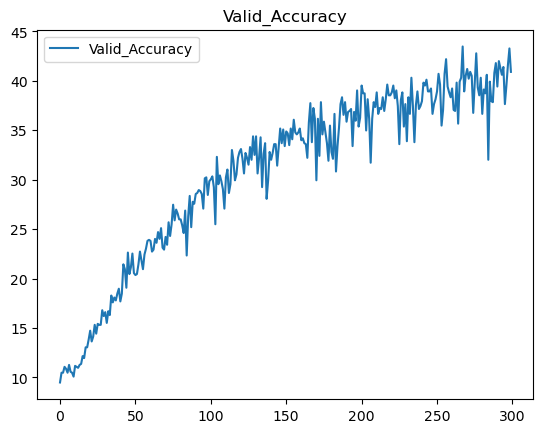

In [18]:
plt.plot(valid_accuracies.get(), label='Valid_Accuracy')
plt.title("Valid_Accuracy")
plt.legend()
plt.savefig(save_subdir + "valid_accuracy_{}.png".format(ts))